### In this seminar we will get get acquainted with [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/). <br> First we look at <u>*NeigborSampler*</u> class and then  train <u>*Graph Attention Network*</u> (GAT, [arXiv:1710.10903](https://arxiv.org/abs/1710.10903)) on CORA dataset, prepared in the previous part.

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.data import NeighborSampler, Data
from torch_geometric.nn import GATConv

In [2]:
data = torch.load('cora_dataset.pt')
data

Data(edge_index=[2, 10556], test_mask=[2708], train_mask=[2708], val_mask=[2708], x=[2708, 1433], y=[2708])

##### <font color='orange'> edge_index </font>  contains graph connectivity information in COO format - each column represents edge in our graph:

In [3]:
data.edge_index

tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [ 633, 1862, 2582,  ...,  598, 1473, 2706]])

### <u>Lets look closer at <font color='Blue'> NeighborSampler </font> for mini-batch training</u>
#### The idea is described in [GraphSAGE paper](https://arxiv.org/abs/1706.02216)

In [4]:
# select only train indices
train_idx = torch.where(data.train_mask)[0]
train_idx

tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
        126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139])

In [5]:
# len of sizes should match number of message passing layers in NN
BATCH_SIZE = 2
train_loader = NeighborSampler(edge_index=data.edge_index,
                               node_idx=train_idx,
                               sizes=[-1, -1],
                               batch_size=BATCH_SIZE,
                               shuffle=False,
                               num_workers=0)

#### Lets do 1 iteration. <br> Sampler will return all crucial information for aggregation for 2 first nodes $[0, 1]$ since we set batch_size=2 and shuffle=False.

In [6]:
first_iter = next(iter(train_loader))
first_iter

(2,
 tensor([   0,    1,  633, 1862, 2582,    2,  652,  654, 1701, 1866,  926, 1166,
          332, 1454, 1666, 1986,  470]),
 [EdgeIndex(edge_index=tensor([[ 2,  3,  4,  5,  6,  7,  0,  8,  9,  0,  4,  8, 10,  0,  3, 11,  1, 12,
           13, 14, 15,  1, 16,  1],
          [ 0,  0,  0,  1,  1,  1,  2,  2,  2,  3,  3,  3,  3,  4,  4,  4,  5,  5,
            5,  5,  5,  6,  6,  7]]), e_id=tensor([ 2569,  7565, 10306,     6,  2640,  2643,     0,  6751,  7578,     1,
          10308,  6787,  3637,     2,  7568,  4551,     3,  1382,  5774,  6597,
           8132,     4,  1932,     5]), size=(17, 8)),
  EdgeIndex(edge_index=tensor([[2, 3, 4, 5, 6, 7],
          [0, 0, 0, 1, 1, 1]]), e_id=tensor([ 2569,  7565, 10306,     6,  2640,  2643]), size=(8, 2))])

#### Each iteration returns a triplet: <font color='Blue'> (bs, n_id, adjs) </font> <br>
- **bs** - batch size
- **n_id** - original indices of all nodes involved in computation for current target nodes.
- **adjs** - list of tuples **(edge_index, e_id, size)** that represent bipartite graphs for each layers

In [7]:
# unpack items
bs, n_id, adjs = first_iter

#### <font color='Blue'>n_id</font> list contains both indices of target nodes $[0, 1]$ and their neighbors $[633, 1862, ..., 470]$. <br> Target nodes are placed at the beginning of the list.

In [8]:
print(len(n_id))
n_id

17


tensor([   0,    1,  633, 1862, 2582,    2,  652,  654, 1701, 1866,  926, 1166,
         332, 1454, 1666, 1986,  470])

#### <font color='Blue'>adjs</font> consist of triplets. Each triplet contains: <br>
- **edge_index** - structure of the [bipartite graph](https://en.wikipedia.org/wiki/Bipartite_graph) corresponding to aggregation from layer $N$ to $N-1$ in **COO** format. <br> **Note**: those are completely *new* graphs so that node indices in  COO edgelists **do not** correspond to original ones. <br>
- **e_id** - denotes **id**'s of those edges in the *original* graph.
- **size** - shape of the current bipartite graph.

In [9]:
adjs

[EdgeIndex(edge_index=tensor([[ 2,  3,  4,  5,  6,  7,  0,  8,  9,  0,  4,  8, 10,  0,  3, 11,  1, 12,
          13, 14, 15,  1, 16,  1],
         [ 0,  0,  0,  1,  1,  1,  2,  2,  2,  3,  3,  3,  3,  4,  4,  4,  5,  5,
           5,  5,  5,  6,  6,  7]]), e_id=tensor([ 2569,  7565, 10306,     6,  2640,  2643,     0,  6751,  7578,     1,
         10308,  6787,  3637,     2,  7568,  4551,     3,  1382,  5774,  6597,
          8132,     4,  1932,     5]), size=(17, 8)),
 EdgeIndex(edge_index=tensor([[2, 3, 4, 5, 6, 7],
         [0, 0, 0, 1, 1, 1]]), e_id=tensor([ 2569,  7565, 10306,     6,  2640,  2643]), size=(8, 2))]

#### <u>Lets take a closer look at neighbor aggregation</u>
##### pictures  below are taken from [Deep Graph Library](https://docs.dgl.ai/guide/index.html) user guide

![title](pictures/MP_layers.png)

##### <u>Layer 2 (2-hop)</u>

![title](pictures/layer_2.png)

##### At layer 2 the goal is to update the states of 1-hop nodes and target node

In [10]:
# bipartite subgraph structure at layer 2 (2-hop)
print(adjs[-2].edge_index.t())

tensor([[ 2,  0],
        [ 3,  0],
        [ 4,  0],
        [ 5,  1],
        [ 6,  1],
        [ 7,  1],
        [ 0,  2],
        [ 8,  2],
        [ 9,  2],
        [ 0,  3],
        [ 4,  3],
        [ 8,  3],
        [10,  3],
        [ 0,  4],
        [ 3,  4],
        [11,  4],
        [ 1,  5],
        [12,  5],
        [13,  5],
        [14,  5],
        [15,  5],
        [ 1,  6],
        [16,  6],
        [ 1,  7]])


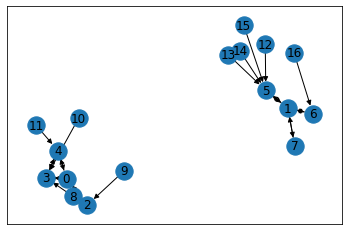

In [11]:
import networkx as nx
from torch_geometric.utils.convert import to_networkx
G = to_networkx(Data(edge_index=adjs[-2].edge_index))
nx.draw_networkx(G)

In [12]:
# edges in the original graph involved in message passing:
data.edge_index[:, adjs[-2].e_id].t()

tensor([[ 633,    0],
        [1862,    0],
        [2582,    0],
        [   2,    1],
        [ 652,    1],
        [ 654,    1],
        [   0,  633],
        [1701,  633],
        [1866,  633],
        [   0, 1862],
        [2582, 1862],
        [1701, 1862],
        [ 926, 1862],
        [   0, 2582],
        [1862, 2582],
        [1166, 2582],
        [   1,    2],
        [ 332,    2],
        [1454,    2],
        [1666,    2],
        [1986,    2],
        [   1,  652],
        [ 470,  652],
        [   1,  654]])

##### <u>Layer 1 (1-hop)</u>

![title](pictures/layer_1.png)

##### At layer 1 the goal is to update the state of target node

In [13]:
# bipartite subgraph structure at layer 2 (2-hop)
print(adjs[-2].edge_index.t())

tensor([[ 2,  0],
        [ 3,  0],
        [ 4,  0],
        [ 5,  1],
        [ 6,  1],
        [ 7,  1],
        [ 0,  2],
        [ 8,  2],
        [ 9,  2],
        [ 0,  3],
        [ 4,  3],
        [ 8,  3],
        [10,  3],
        [ 0,  4],
        [ 3,  4],
        [11,  4],
        [ 1,  5],
        [12,  5],
        [13,  5],
        [14,  5],
        [15,  5],
        [ 1,  6],
        [16,  6],
        [ 1,  7]])


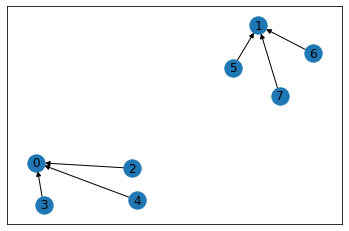

In [14]:
G = to_networkx(Data(edge_index=adjs[-1].edge_index))
nx.draw_networkx(G)

In [15]:
# edges in the original graph involved in message passing:
data.edge_index[:, adjs[-1].e_id].t()

tensor([[ 633,    0],
        [1862,    0],
        [2582,    0],
        [   2,    1],
        [ 652,    1],
        [ 654,    1]])

#### As we can see, all 1-hop edges ( $[633, 0]$, ... , $[2582, 0]$,  $[2, 1]$, ..., $[654, 1]$ ) are also included in 2-hop calculation.

### <u><font color='Red'> Training the model</font></u>

#### The model is heavily based on [PyTorch Geometric examples](https://github.com/rusty1s/pytorch_geometric/tree/master/examples)

In [16]:
data

Data(edge_index=[2, 10556], test_mask=[2708], train_mask=[2708], val_mask=[2708], x=[2708, 1433], y=[2708])

In [17]:
data.num_features

1433

#### Define Dataloaders

In [18]:
train_idx = torch.where(data.train_mask)[0]
val_idx = torch.where(data.val_mask)[0]
test_idx = torch.where(data.test_mask)[0]


train_loader = NeighborSampler(data.edge_index,
                               node_idx=train_idx,
                               sizes=[-1, -1],
                               batch_size=512,
                               shuffle=True,
                               num_workers=0)

subgraph_loader = NeighborSampler(data.edge_index,
                                  node_idx=None,
                                  sizes=[-1],
                                  batch_size=1024,
                                  shuffle=False,
                                  num_workers=0)

#### Class for Graph Attention Model

* **forward** <br> For each layer performs <font color='Red'>**Message Passing**</font> using bipartite graph structures obtained from DataLoader. <br> During *training phase* for each batch of nodes all layers are applied sequentially: **batch iterator** $\longrightarrow $ **layers iterator**. In other words, we compute final states for each batch and then iterate to other batch.
* **inference** <br> Inference of the model on the whole graph. <br> During *inference phase* we perform message passing on the whole graph for each layer: **layers iterator** $\longrightarrow $ **batch iterator**.

In [19]:
class GAT(torch.nn.Module):
    def __init__(self,
                 in_channels,
                 hidden_channels,
                 out_channels,
                 num_layers,  # num_classes
                 heads):
        
        super(GAT, self).__init__()

        self.num_layers = num_layers

        self.convs = torch.nn.ModuleList()
        self.convs.append(GATConv(data.num_features,
                                  hidden_channels,
                                  heads)
                         )
        
        for _ in range(num_layers - 2):
            self.convs.append(GATConv(heads * hidden_channels,
                                      hidden_channels,
                                      heads)
                             )
            
        self.convs.append(GATConv(heads * hidden_channels,
                                  out_channels,
                                  heads,
                                  concat=False)
                         )

        self.skips = torch.nn.ModuleList()
        self.skips.append(nn.Linear(data.num_features,
                              hidden_channels * heads)
                         )
        
        for _ in range(num_layers - 2):
            self.skips.append(nn.Linear(hidden_channels * heads,
                                  hidden_channels * heads)
                             )
            
        self.skips.append(nn.Linear(hidden_channels * heads,
                              out_channels)
                         )

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for skip in self.skips:
            skip.reset_parameters()

    def forward(self, x, adjs):
        for i, (edge_index, _, size) in enumerate(adjs):
            x_target = x[:size[1]]  # Target nodes are always placed first.
            x = self.convs[i]((x, x_target), edge_index)
            x = x + self.skips[i](x_target)
            if i != self.num_layers - 1:
                x = F.elu(x)
                x = F.dropout(x, p=0.5, training=self.training)
        return x.log_softmax(dim=-1)

    def inference(self, x_all):

        total_edges = 0
        for i in range(self.num_layers):
            xs = []
            for batch_size, n_id, adj in subgraph_loader:
                edge_index, _, size = adj.to(device)
                total_edges += edge_index.size(1)
                x = x_all[n_id].to(device)
                x_target = x[:size[1]]
                x = self.convs[i]((x, x_target), edge_index)
                x = x + self.skips[i](x_target)

                if i != self.num_layers - 1:
                    x = F.elu(x)
                xs.append(x) #x.cpu()

            x_all = torch.cat(xs, dim=0)

        return x_all

#### Initialize  GAT model

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GAT(in_channels=data.num_features,
            hidden_channels=128,
            out_channels=7,  # num_classes
            num_layers=2,
            heads=4)

model = model.to(device)

x = data.x.to(device)
y = data.y.squeeze().to(device)

In [21]:
#number of parameters
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_params

1487430

#### Training Loop

In [22]:
def train(epoch):
    model.train()  # Sets the modules in training mode. Affects dropouts, batchnorms, ...
    total_loss = total_correct = 0
    for batch_size, n_id, adjs in train_loader:
        # `adjs` holds a list of `(edge_index, e_id, size)` tuples.
        adjs = [adj.to(device) for adj in adjs]

        optimizer.zero_grad()
        out = model(x[n_id], adjs) # [batch_size, num_classes]
        
        # n_id - all nodes (targets + others) involved in message passing
        loss = F.nll_loss(out, y[n_id[:batch_size]])  # targets are first
        
        loss.backward()
        optimizer.step()

        total_loss += float(loss)
        
        #number of correct predictions (probability cutoff = 50% <=> class with highest probability)
        total_correct += int((out.argmax(dim=-1) == y[n_id[:batch_size]]).sum())
        
    loss = total_loss / len(train_loader)
    approx_acc = total_correct / train_idx.size(0)

    return loss, approx_acc

#### @torch.no_grad() 
is a decorator for [disabling gradient calculation](https://pytorch.org/docs/stable/generated/torch.no_grad.html).
Same meaning as **with torch.no_grad():** statement.

In [23]:
@torch.no_grad()
def validate():
    model.eval()  # Sets the modules in evaluation mode. Affects dropouts, batchnorms, ...

    out = model.inference(x) # [num_nodes, num_classes] - whole graph
  
    train_loss = F.nll_loss(out[train_idx].log_softmax(dim=-1), y[train_idx])
    val_loss = F.nll_loss(out[val_idx].log_softmax(dim=-1), y[val_idx])
    test_loss = F.nll_loss(out[test_idx].log_softmax(dim=-1), y[test_idx])
    
    
    train_acc = int((out[train_idx].argmax(dim=-1) == y[train_idx]).sum()) / len(y[train_idx])
    val_acc = int((out[val_idx].argmax(dim=-1) == y[val_idx]).sum()) / len(y[val_idx])
    test_acc = int((out[test_idx].argmax(dim=-1) == y[test_idx]).sum()) / len(y[test_idx])
    
    loss_dict = {'train_loss': train_loss,
               'val_loss': val_loss,
               'test_loss:': test_loss}
    
    acc_dict = {'train_acc': train_acc,
               'val_acc': val_acc,
               'test_acc:': test_acc}
    
    return loss_dict, acc_dict

In [24]:
model.reset_parameters()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

best_val_loss = np.inf

VERBOSE = 10
for epoch in range(1, 101):
    loss, acc = train(epoch)
    loss_dict, val_dict = validate()
    
    if epoch % VERBOSE == 0:
        print(f'Epoch {epoch:02d}, Loss: {loss:.4f}, Approx. Acc. Train: {acc:.4f}')
        print(f'Validation on epoch {epoch:02d}:')
        print(', '.join([f'{name}: {value:.2f}' for name, value in loss_dict.items()]))
        print(', '.join([f'{name}: {value:.2f}' for name, value in val_dict.items()]), end='\n\n')

    val_loss = loss_dict['val_loss']
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'GAT_model.pt')

Epoch 10, Loss: 1.7359, Approx. Acc. Train: 0.8000
Validation on epoch 10:
train_loss: 1.72, val_loss: 1.84, test_loss:: 1.84
train_acc: 0.87, val_acc: 0.54, test_acc:: 0.57

Epoch 20, Loss: 1.5295, Approx. Acc. Train: 0.9714
Validation on epoch 20:
train_loss: 1.52, val_loss: 1.75, test_loss:: 1.75
train_acc: 0.99, val_acc: 0.69, test_acc:: 0.71

Epoch 30, Loss: 1.3409, Approx. Acc. Train: 0.9929
Validation on epoch 30:
train_loss: 1.32, val_loss: 1.66, test_loss:: 1.65
train_acc: 0.99, val_acc: 0.73, test_acc:: 0.75

Epoch 40, Loss: 1.1576, Approx. Acc. Train: 0.9929
Validation on epoch 40:
train_loss: 1.14, val_loss: 1.57, test_loss:: 1.56
train_acc: 0.99, val_acc: 0.75, test_acc:: 0.77

Epoch 50, Loss: 0.9879, Approx. Acc. Train: 0.9929
Validation on epoch 50:
train_loss: 0.96, val_loss: 1.49, test_loss:: 1.47
train_acc: 0.99, val_acc: 0.76, test_acc:: 0.78

Epoch 60, Loss: 0.8214, Approx. Acc. Train: 1.0000
Validation on epoch 60:
train_loss: 0.80, val_loss: 1.40, test_loss:: 1.38